In [3]:
# =============================================
# Quant Momentum Report.ipynb
# 국내 급등주 전략 백테스트 + 섹터 분석 리포트
# =============================================

# 📌 자동 리로드 활성화 (파일 수정 시 자동 반영)
%load_ext autoreload
%autoreload 2

import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import date
from config import *
from data_loader import get_universe, load_panel, get_index_close, infer_market
from signals import compute_indicators, add_rel_strength, scoring
from positioner import select_candidates
from utils import perf_stats

plt.rcParams['font.family'] = 'AppleGothic'  # mac용 한글폰트
plt.rcParams['axes.unicode_minus'] = False



In [4]:
# ============ 기본 설정 ============
MARKETS = ("KOSPI", "KOSDAQ")
# if len(sys.argv) > 1:
#     m = sys.argv[1].upper()
#     if m in ("KOSPI", "KOSDAQ"):
#         MARKETS = (m,)
# START = "2020-01-01"
# END = date.today().strftime("%Y-%m-%d")
# MAX_WORKERS = 4     # 병렬 수 제한 (KRX 서버 안전치)
# CHUNK_SIZE = 100    # 한 번에 처리할 종목 수
# RETRY_LIMIT = 3

In [5]:
# ---------------------------------------------
# 1️⃣ 데이터 로드 & 준비
# ---------------------------------------------
print("📂 데이터 로드 중...")

universe = get_universe(MARKETS)
panel = load_panel(universe, START, END, max_workers=6)
print(f"✅ 로드 완료: {len(panel)}개 종목")

idx_map = {"KOSPI": get_index_close("KOSPI", START, END),
           "KOSDAQ": get_index_close("KOSDAQ", START, END)}



📂 데이터 로드 중...
[INFO] Loading 2490 tickers (parallel=6)
  Progress: 50/2490 (2.0%)
  Progress: 100/2490 (4.0%)
  Progress: 150/2490 (6.0%)
  Progress: 200/2490 (8.0%)
  Progress: 250/2490 (10.0%)
  Progress: 300/2490 (12.0%)
  Progress: 350/2490 (14.1%)
  Progress: 400/2490 (16.1%)
  Progress: 450/2490 (18.1%)
  Progress: 500/2490 (20.1%)
  Progress: 550/2490 (22.1%)
  Progress: 600/2490 (24.1%)
  Progress: 650/2490 (26.1%)
  Progress: 700/2490 (28.1%)
  Progress: 750/2490 (30.1%)
  Progress: 800/2490 (32.1%)
  Progress: 850/2490 (34.1%)
  Progress: 900/2490 (36.1%)
  Progress: 950/2490 (38.2%)
  Progress: 1000/2490 (40.2%)
  Progress: 1050/2490 (42.2%)
  Progress: 1100/2490 (44.2%)
  Progress: 1150/2490 (46.2%)
  Progress: 1200/2490 (48.2%)
  Progress: 1250/2490 (50.2%)
  Progress: 1300/2490 (52.2%)
  Progress: 1350/2490 (54.2%)
  Progress: 1400/2490 (56.2%)
  Progress: 1450/2490 (58.2%)
  Progress: 1500/2490 (60.2%)
  Progress: 1550/2490 (62.2%)
  Progress: 1600/2490 (64.3%)
  Progres

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd

# ---------------------------------------------
# 1️⃣ 시그널 생성 (병렬 + tqdm)
# ---------------------------------------------
print("⚙️ 시그널 계산 시작...")

def build_signal_for_one(ticker, df, idx_map, infer_market_fn):
    """한 종목의 indicator + relative strength 계산"""
    try:
        if df is None or df.empty:
            return ticker, pd.DataFrame()

        mkt = infer_market_fn(ticker) or "KOSPI"

        # ---- 지표 계산 ----
        df = compute_indicators(df)
        if df is None or df.empty:
            return ticker, pd.DataFrame()

        # ---- 상대강도 계산 ----
        df = add_rel_strength(df, idx_map[mkt])
        return ticker, df

    except Exception as e:
        return ticker, pd.DataFrame()

# ---- 실행 ----
MAX_WORKERS = 8  # CPU 코어 개수에 맞게 조절 (M1/M2는 6~10 적당)
fails = []
enriched = {}

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = {
        ex.submit(build_signal_for_one, t, df, idx_map, infer_market): t
        for t, df in panel.items()
    }

    for f in tqdm(as_completed(futs), total=len(futs), desc="Signals"):
        t = futs[f]
        try:
            k, out = f.result()
            if not out.empty:
                enriched[k] = out
        except Exception as e:
            fails.append((t, str(e)))

print(f"✅ 시그널 생성 완료: {len(enriched)}개 / 실패 {len(fails)}개")
if fails:
    print("❌ 일부 실패 예시:", fails[:5])

⚙️ 시그널 계산 시작...


Signals: 100%|██████████| 2460/2460 [00:19<00:00, 125.57it/s]

✅ 시그널 생성 완료: 2460개 / 실패 0개


In [7]:
# =============================================
# 2️⃣ 신호 생성 및 백테스트 (tqdm + 최적화 + 옵션 병렬)
# =============================================
print("⚙️ 전략 시그널 계산 및 백테스트 시작...")

# (전제) enriched = {ticker: df(with indicators+RS)} 가 준비되어 있어야 함
# 만약 아직이라면, 별도 병렬 시그널 생성 루틴으로 enriched 먼저 만드세요.

# ---- 파라미터 & 옵션 ----
USE_PARALLEL_ROWS = False   # ✅ 날짜별 rows 생성 병렬화 (대부분 환경에선 OFF가 더 빠름)
ROW_WORKERS       = 8       # rows 병렬화 사용시 쓰레드 수
MIN_ROWS_FOR_PAR  = 1000    # rows 수가 이 값 이상일 때만 병렬화 시도

# 백테스트 상태
cash = 1_000_000_000.0   # 초기자본 10억
positions = {}
equity_curve = []
trade_log = []

# 공통 거래일 (정렬)
dates = sorted(set().union(*[df.index for df in enriched.values()]))

# ---- 미세 최적화: 자주 쓰는 상수/함수 로컬 바인딩 ----
STOP_LOSS_ = STOP_LOSS
TAKE_PROFIT_ = TAKE_PROFIT
MAX_HOLD_DAYS_ = MAX_HOLD_DAYS
FEE_PER_SIDE_ = FEE_PER_SIDE
VENUE_FEE_PER_SIDE_ = VENUE_FEE_PER_SIDE
TAX_RATE_SELL_ = TAX_RATE_SELL
SLIP_IN_  = SLIPPAGE_ENTRY
SLIP_OUT_ = SLIPPAGE_EXIT
MIN_LIQ_  = MIN_AVG_TRD_AMT_20
MAX_HOLDINGS_ = MAX_HOLDINGS
MAX_W_PER = MAX_WEIGHT_PER_NAME
FORBID_LU = FORBID_LIMIT_UP_ENTRY
score_fn  = scoring
W_        = W

tickers = list(enriched.keys())
get_df  = enriched.get

def _row_for_ticker(t, d0, d1):
    """한 종목의 d0/d1 자료를 rows dict로 변환 (빠른 경로, 예외시 None)"""
    df = get_df(t)
    if df is None:
        return None
    try:
        # .loc 2회 대신 빠른 단건 접근
        if d0 not in df.index or d1 not in df.index:
            return None
        r0 = df.loc[d0]
        o1 = df.at[d1, "open"]

        # 상한가 당일 진입 금지 옵션
        price_ok = False if (FORBID_LU and r0["lc"] == 1) else True

        return {
            "ticker": t,
            "close":    r0["close"],
            "open_next":o1,
            "val_ma20": r0["val_ma20"],
            "v_mult":   r0["v_mult"],
            "bo":       r0["bo"],
            "vcp":      r0["vcp"],
            "gg":       r0["gg"],
            "lc":       r0["lc"],
            "rs_raw":   r0.get("rs_raw", np.nan),
            "price_ok": price_ok
        }
    except Exception:
        return None

def _build_rows_serial(d0, d1):
    out = []
    append = out.append
    for t in tickers:
        row = _row_for_ticker(t, d0, d1)
        if row is not None:
            append(row)
    return out

def _build_rows_parallel(d0, d1):
    out = []
    append = out.append
    with ThreadPoolExecutor(max_workers=ROW_WORKERS) as ex:
        futs = [ex.submit(_row_for_ticker, t, d0, d1) for t in tickers]
        for f in as_completed(futs):
            row = f.result()
            if row is not None:
                append(row)
    return out

# ---- 날짜 루프 (tqdm 진행률 표시) ----
for i in tqdm(range(60, len(dates) - 1), total=max(0, len(dates) - 1 - 60), desc="Backtest"):
    d0, d1 = dates[i], dates[i+1]

    # rows 생성 (대부분은 직렬이 더 빠름; 아주 큰 유니버스면 병렬로)
    if USE_PARALLEL_ROWS and len(tickers) >= MIN_ROWS_FOR_PAR:
        rows = _build_rows_parallel(d0, d1)
    else:
        rows = _build_rows_serial(d0, d1)

    # 거래 후보가 없을 때는 자산 그대로
    if not rows:
        equity_curve.append((d0, cash))
        continue

    day = pd.DataFrame(rows).set_index("ticker")

    # 점수 계산 (RS는 퍼센타일 rank)
    day["score"] = score_fn(day, W_)

    # --------- 청산 ----------
    to_close = []
    for t, pos in list(positions.items()):
        df_t = get_df(t)
        if df_t is None or d0 not in df_t.index:
            continue
        px = df_t.at[d0, "close"]
        ret = px / pos["entry_px"] - 1.0
        held = (d0 - pos["entry_date"]).days
        if (ret <= STOP_LOSS_) or (ret >= TAKE_PROFIT_) or (held >= MAX_HOLD_DAYS_):
            to_close.append(t)

    for t in to_close:
        df_t = get_df(t)
        if df_t is None or d1 not in df_t.index:
            continue
        px = df_t.at[d1, "open"] * (1.0 - SLIP_OUT_)
        qty = positions[t]["qty"]
        gross = px * qty
        fee  = gross * (FEE_PER_SIDE_ + VENUE_FEE_PER_SIDE_)
        tax  = gross * TAX_RATE_SELL_
        cash += (gross - fee - tax)
        trade_log.append({"date": d1, "ticker": t, "exit_px": px, "ret": px/positions[t]["entry_px"] - 1.0})
        del positions[t]

    # --------- 신규 진입 ----------
    # 유동성/체결가능 필터
    candidates = day[(day["val_ma20"] >= MIN_LIQ_) & (day["price_ok"])]
    if not candidates.empty:
        picks = candidates.sort_values("score", ascending=False).head(MAX_HOLDINGS_)
        slots = max(0, MAX_HOLDINGS_ - len(positions))
        if slots > 0:
            picks = picks.head(slots)
            target_w = min(1.0 / max(1, len(positions) + len(picks)), MAX_W_PER)
            alloc_cash = cash * target_w
            for t, r in picks.iterrows():
                px = r["open_next"] * (1.0 + SLIP_IN_)
                
                # ✅ px가 0, inf, nan인 경우 건너뛰기
                if px <= 0 or not np.isfinite(px):
                    continue
                
                qty = int(alloc_cash / px)
                if qty <= 0:
                    continue
                notional = qty * px
                fee = notional * (FEE_PER_SIDE_ + VENUE_FEE_PER_SIDE_)
                new_cash = cash - notional - fee
                if new_cash < 0:
                    continue
                cash = new_cash
                positions[t] = {"entry_px": px, "qty": qty, "entry_date": d1}

    # --------- 자산 기록 ----------
    equity = cash
    for t, pos in positions.items():
        df_t = get_df(t)
        if df_t is not None and d0 in df_t.index:
            equity += df_t.at[d0, "close"] * pos["qty"]
    equity_curve.append((d0, equity))

# ---------------------------------------------
# 💾 equity_curve → DataFrame 변환
# ---------------------------------------------
ec = pd.DataFrame(equity_curve, columns=["date", "equity"]).set_index("date")
print(f"✅ Equity curve 생성 완료: {len(ec)}개 데이터 포인트")

⚙️ 전략 시그널 계산 및 백테스트 시작...


Backtest: 100%|██████████| 1375/1375 [02:00<00:00, 11.39it/s]

✅ Equity curve 생성 완료: 1375개 데이터 포인트


In [10]:
from backtest_sector_weight import backtest_with_sector_weight
# ---------------------------------------------
# 3️⃣ 성과 지표 출력
# ---------------------------------------------
ec, trades = backtest_with_sector_weight(enriched, W=W)
stats = perf_stats(ec)
print("\n📊 성과 요약")
for k,v in stats.items():
    print(f"{k:<8}: {v:.4f}")



SectorBacktest:   0%|          | 0/1375 [00:00<?, ?it/s]


KeyError: 'lc'

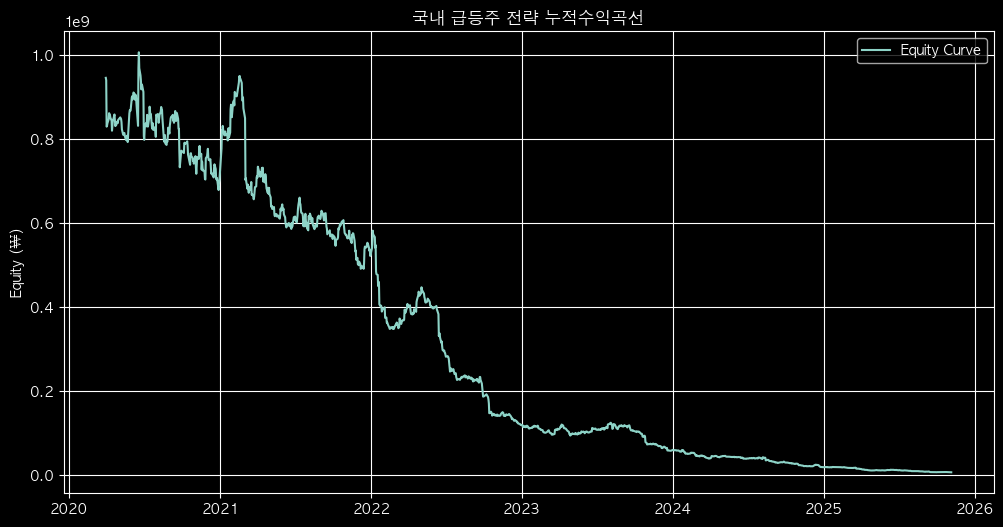

In [11]:
# ---------------------------------------------
# 4️⃣ 성과 시각화
# ---------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(ec.index, ec["equity"], label="Equity Curve")
plt.title("국내 급등주 전략 누적수익곡선")
plt.ylabel("Equity (₩)")
plt.legend()
plt.grid(True)
plt.show()



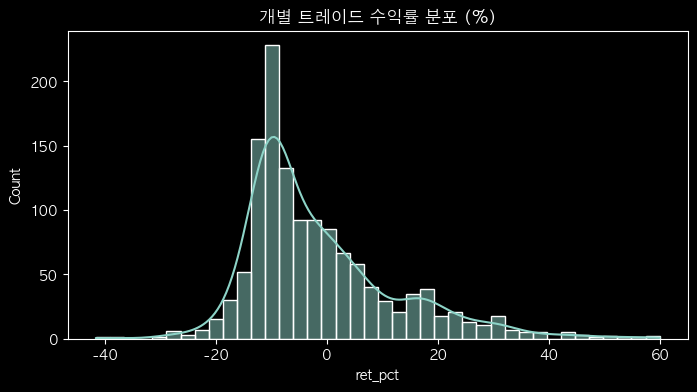

✅ 승률: 34.3% | 평균익절: 13.54% | 평균손절: -9.24% | Payoff: 1.47


In [12]:
# ---------------------------------------------
# 5️⃣ 트레이드 분포 분석
# ---------------------------------------------
trades = pd.DataFrame(trade_log)
if len(trades) > 0:
    trades["ret_pct"] = trades["ret"] * 100
    plt.figure(figsize=(8,4))
    sns.histplot(trades["ret_pct"], bins=40, kde=True)
    plt.title("개별 트레이드 수익률 분포 (%)")
    plt.show()
    win_rate = (trades["ret"]>0).mean()
    avg_gain = trades.loc[trades["ret"]>0,"ret"].mean()
    avg_loss = trades.loc[trades["ret"]<0,"ret"].mean()
    payoff = abs(avg_gain / avg_loss)
    print(f"✅ 승률: {win_rate*100:.1f}% | 평균익절: {avg_gain*100:.2f}% | 평균손절: {avg_loss*100:.2f}% | Payoff: {payoff:.2f}")
else:
    print("⚠️ 아직 트레이드 로그가 충분하지 않습니다.")



In [ ]:
# ---------------------------------------------
# 6️⃣ 섹터별 수익률 분석 (선택적)
# ---------------------------------------------
# 향후 FnGuide 섹터코드 매핑 시 추가 예정

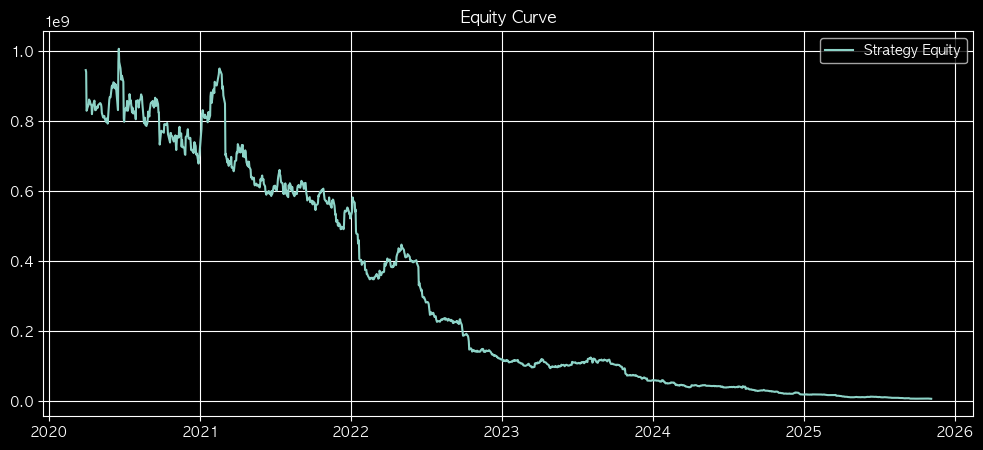

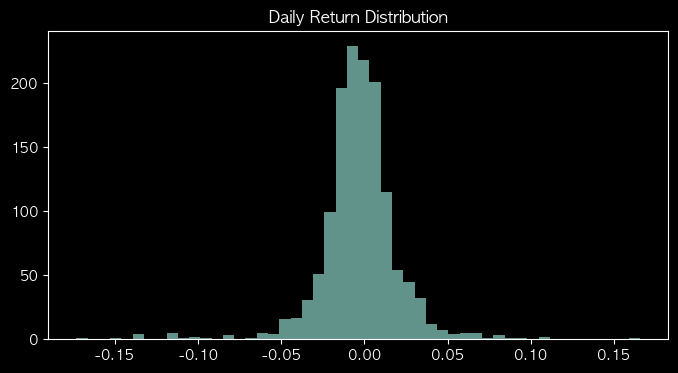

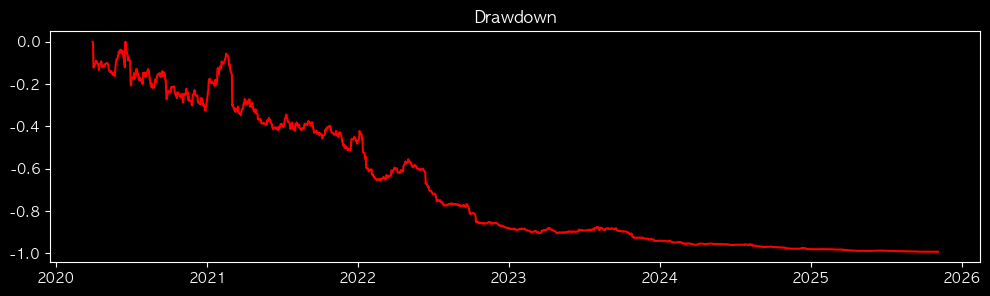

최대낙폭(MDD): -99.25%


In [13]:
# Equity curve plot
plt.figure(figsize=(12,5))
plt.plot(ec.index, ec["equity"], label="Strategy Equity")
plt.title("Equity Curve")
plt.legend()
plt.grid(True)
plt.show()

# 일간 수익률 분포
rets = ec["equity"].pct_change().dropna()
plt.figure(figsize=(8,4))
plt.hist(rets, bins=50, alpha=0.7)
plt.title("Daily Return Distribution")
plt.show()

# 누적 최대낙폭 (MDD)
cummax = ec["equity"].cummax()
dd = ec["equity"]/cummax - 1
plt.figure(figsize=(12,3))
plt.plot(dd.index, dd, color='red')
plt.title("Drawdown")
plt.show()

print(f"최대낙폭(MDD): {dd.min():.2%}")